In [1]:
# !pip install scikit-learn=='0.24.2'
# !pip install transformers
# !pip install torch
# !pip install numpy
# !pip install seaborn
# !pip install pandas
# !pip install tqdm
# !pip install collections
# !pip install matplotlib

In [1]:
import transformers 
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt

### Read data

In [2]:
file = './data/dataset1.csv'
df = pd.read_csv(file)

In [3]:
# Viewing columns 'sentiScore' Distribution
df['sentiScore'].value_counts()

 3.0    1518
 2.0     918
-1.0     628
 4.0     242
-2.0     153
-3.0     132
-4.0      77
 5.0      15
-5.0       8
Name: sentiScore, dtype: int64

In [4]:
# Predictive label conversion
df['label'] = np.where(df['sentiScore']>0,1,0)

In [5]:
# Remove dirty data, e.g. null values, no label data
df = df[(df['id']>0) & (df['review'].str.len()>0)][['label','review']]

### Setting device as per the availability

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
# Pre-trained models using bert
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [8]:
# Using the bert tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Loading pre-trained bert tokenizer 

100%|██████████| 3689/3689 [00:03<00:00, 1181.42it/s]
<ipython-input-9-18bf43279432>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


<Axes: ylabel='Density'>

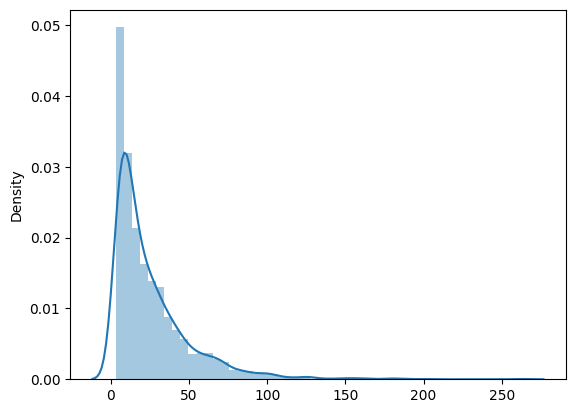

In [9]:
# Statistical distribution of sentence lengths
token_lens = []
for txt in tqdm(df.review):
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

sns.distplot(token_lens)

In [10]:
# The maximum sentence length can be chosen from the above diagram to be 100
# as most sentences are less than 100 in length
MAX_LEN = 100

In [11]:
# Encoding of the input sentence sequence
class ReviewDataset(Dataset):
    def __init__(self,reviews,targets,tokenizer,max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

### Creating Pytorch dataset by converting the text into numerical vectors using the tokenizer 

In [12]:
# dataset slicing
df_train = df.sample(frac=0.7,random_state=0,axis=0)
df_temp = df[~df.index.isin(df_train.index)]
df_val = df_temp.sample(frac=0.5,random_state=0,axis=0)
df_test = df_temp[~df_temp.index.isin(df_val.index)]

In [13]:
df_train.label.value_counts()

1    1885
0     697
Name: label, dtype: int64

Train


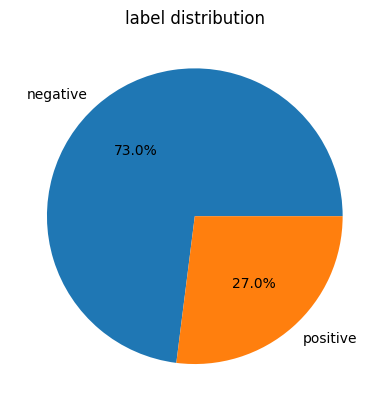

Label distribution:  {1: 1885, 0: 697}
Val


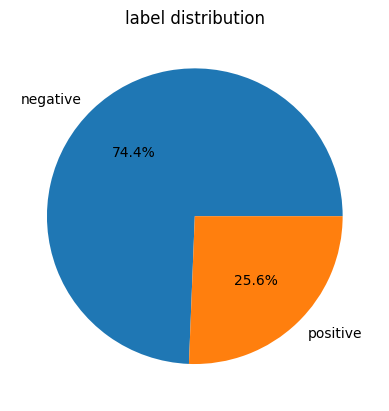

Label distribution:  {1: 412, 0: 142}
Test


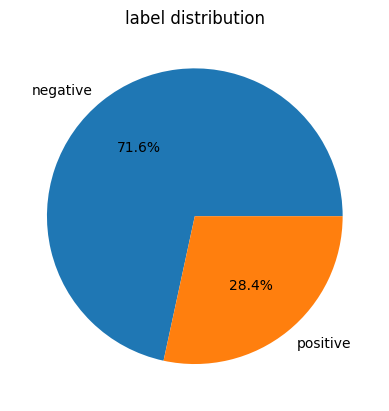

Label distribution:  {1: 396, 0: 157}


In [38]:
def describe_label_distribution(label):
    """plot the distribution of label"""
    plt.pie(label, labels=['negative','positive'], autopct='%1.1f%%')
    plt.title('label distribution')
    plt.show()
    print('Label distribution: ', label.to_dict())


print('Train')
describe_label_distribution(df_train.label.value_counts())
print('Val')
describe_label_distribution(df_val.label.value_counts())
print('Test')
describe_label_distribution(df_test.label.value_counts())

In [15]:
# Obtain and calculate class weights. 
# Adding these weights to a small number of classes while training the model can improve the classification performance of the classes.
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(df_train.label.values),
                                                 y=df_train.label.values)

In [16]:
# print class weights
class_weights

array([1.85222382, 0.68488064])

In [17]:
# Define data loader
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = ReviewDataset(
        reviews = df.review.to_numpy(), 
        targets = df.label.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=0)

### Creating Pytorch dataset loader 

In [18]:
BATCH_SIZE = 32
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [19]:
# Download bert pre-trained model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
bert_model.config.hidden_size

768

In [21]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes=2):
        super(SentimentClassifier, self).__init__()

        # Load pre-trained BERT model and freeze its parameters
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        for param in self.bert.parameters():
            param.requires_grad = False

        # Set up bidirectional LSTM
        hidden_size = 128
        self.lstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

        # Set up final classification layer
        self.fc = nn.Linear(hidden_size*2, n_classes) # Multiply by 2 since the LSTMs are bidirectional

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state 

        hidden_size = 128
        lstm_output, _ = self.lstm(bert_output) # Use the last hidden state (output) from the BERT model
        # Use only the final hidden states (last output states) from the LSTM in the classification layer
        hidden = torch.cat((lstm_output[:, -1, :hidden_size], lstm_output[:, 0, hidden_size:]), dim=1)
        logits = self.fc(hidden)
        return logits

### Creating a fine-tuned bert model 

In [22]:
class_name = ['negative','positive']

In [23]:
model = SentimentClassifier(len(class_name))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
# Define the rounds of training
EPOCHS = 5
# Use AdamW Optimiser
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# Define cross-entropy loss
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Initializing optimizer and loss function for our model

In [25]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

### Function to train our model on each epoch

In [26]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

### Function to evaluate the model

In [27]:
# Training process and print the loss and acc of train and val for each round
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/5
----------
Train loss 0.5668425158953961 accuracy 0.7149496514329977
Val   loss 0.49623464544614154 accuracy 0.7436823104693141

Epoch 2/5
----------
Train loss 0.47127098580937327 accuracy 0.7420604182804028
Val   loss 0.4008375538720025 accuracy 0.8158844765342961

Epoch 3/5
----------
Train loss 0.4120276833390012 accuracy 0.801704105344694
Val   loss 0.37933868914842606 accuracy 0.8194945848375451

Epoch 4/5
----------
Train loss 0.3980414206966942 accuracy 0.8156467854376452
Val   loss 0.3731127596563763 accuracy 0.8176895306859207

Epoch 5/5
----------
Train loss 0.3937178796824114 accuracy 0.8226181254841208
Val   loss 0.37108494424157673 accuracy 0.8140794223826715



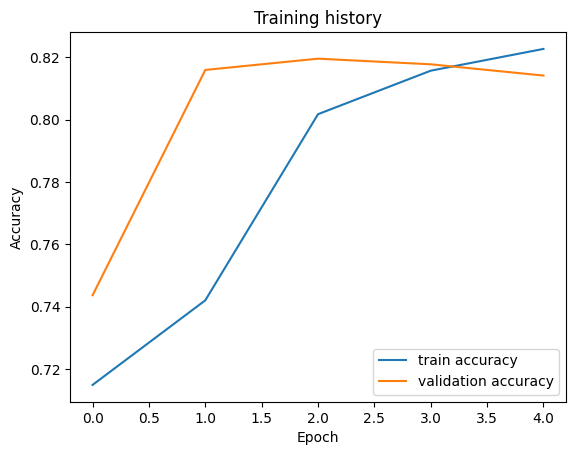

In [28]:
plt.plot(torch.tensor(history["train_acc"], device='cpu'), label='train accuracy')
plt.plot(torch.tensor(history["val_acc"], device='cpu'), label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [29]:
# TestSet Evaluation
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)


test_acc.item()

0.833634719710669

In [30]:
# prediction validation
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [31]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [32]:
# Reporting on indicators of classification results
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

    negative       0.76      0.60      0.67       157
    positive       0.85      0.93      0.89       396

    accuracy                           0.83       553
   macro avg       0.81      0.76      0.78       553
weighted avg       0.83      0.83      0.83       553



Test set prediction distribution

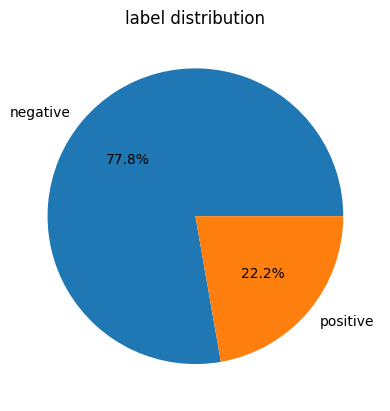

Label distribution:  {1: 430, 0: 123}


In [35]:
labels = pd.value_counts(y_pred.numpy())
describe_label_distribution(labels)

Train set prediction distribution

In [36]:
_, y_train_pred, _, _ = get_predictions(
  model,
  train_data_loader
)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


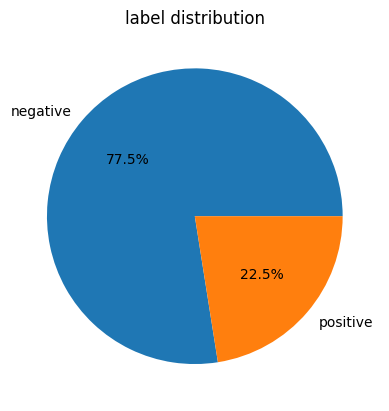

Label distribution:  {1: 2001, 0: 581}


In [37]:
labels = pd.value_counts(y_train_pred.numpy())
describe_label_distribution(labels)

In [39]:
# Dichotomous confusion matrix plotting and ROC curve plotting
def binary_performances(y_true, y_prob, thresh=0.5, labels=['Positives','Negatives']):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, auc, roc_curve
    
    shape = y_prob.shape
    if len(shape) > 1:
        if shape[1] > 2:
            raise ValueError('A binary class problem is required')
        else:
            y_prob = y_prob[:,1]
    
    plt.figure(figsize=[15,4])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y_true, (y_prob>thresh))
    
    plt.subplot(121)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                     annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
               'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
    
    #2 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(122)
    plt.plot(fp_rates, tp_rates, color='orange',
             lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()

    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    results = {
        "Precision": precision, "Recall": recall,
        "F1 Score": F1, "AUC": roc_auc
    }
    
    prints = [f"{kpi}: {round(score, 3)}" for kpi,score in results.items()]
    prints = ' | '.join(prints)
    print(prints)
    
    return results

<ipython-input-40-10721b2720ff>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  binary_performances(torch.tensor(y_test, device='cpu'), torch.tensor(y_pred, device='cpu'), thresh=0.5, labels=['Positives','Negatives'])


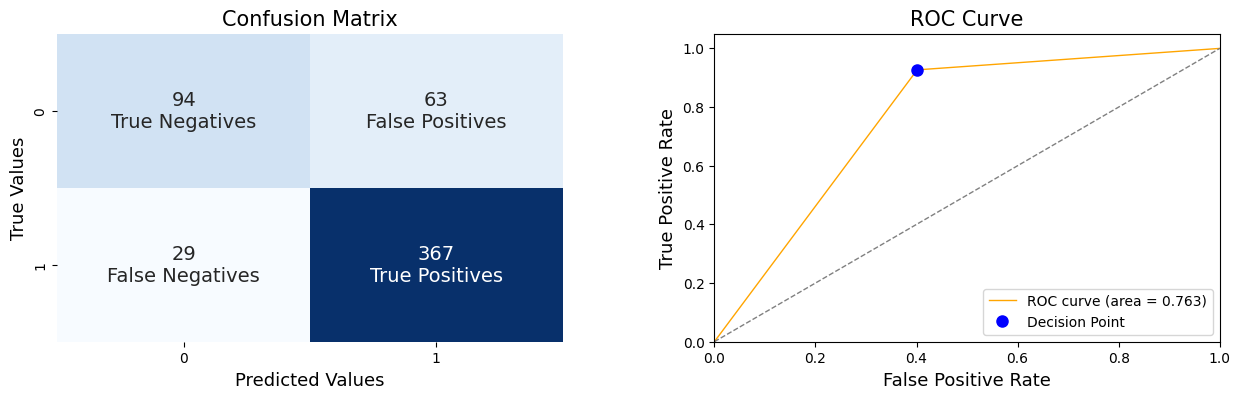

Precision: 0.853 | Recall: 0.927 | F1 Score: 0.889 | AUC: 0.763


{'Precision': 0.8534883720930233,
 'Recall': 0.9267676767676768,
 'F1 Score': 0.8886198547215498,
 'AUC': 0.7627468957086792}

In [40]:
binary_performances(torch.tensor(y_test, device='cpu'), torch.tensor(y_pred, device='cpu'), thresh=0.5, labels=['Positives','Negatives'])

/tmp/ipykernel_179/1713052172.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  binary_performances(torch.tensor(y_test, device='cpu'), torch.tensor(y_pred, device='cpu'), thresh=0.5, labels=['Positives','Negatives'])


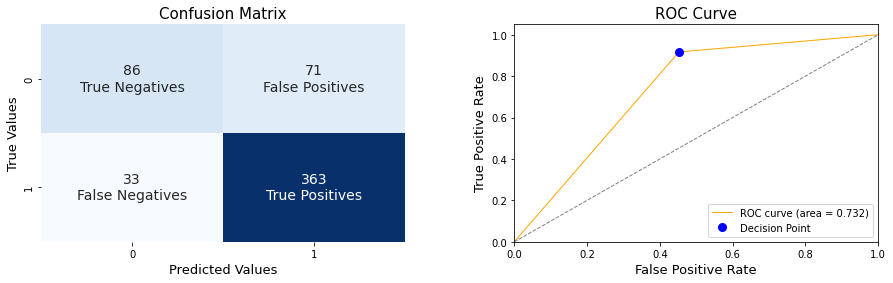

Precision: 0.836 | Recall: 0.917 | F1 Score: 0.875 | AUC: 0.732


{'Precision': 0.836405529953917,
 'Recall': 0.9166666666666666,
 'F1 Score': 0.8746987951807228,
 'AUC': 0.7322186836518046}

In [ ]:
binary_performances(torch.tensor(y_test, device='cpu'), torch.tensor(y_pred, device='cpu'), thresh=0.5, labels=['Positives','Negatives'])

### Data Prediction

In [ ]:
review_text = "the food was delicious but it was spicy"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/root/miniconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_name[prediction]}')

Review text: the food was delicious but it was spicy
Sentiment  : positive
